### Install and import packages

In [ ]:
# ! pip install wordcloud matplotlib kagglehub torchaudio
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import kagglehub
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, WhisperProcessor, WhisperForConditionalGeneration
from jiwer import wer, cer
import torchaudio
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BILLY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BILLY\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BILLY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. EDA (Exploratory Data Analysis)

In [3]:
df = pd.read_csv("dataset/transcriptions.csv")
df.head()

,idx,user_ids,accent,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,gender
0,7252,AKHONA,eng_sot,ZA,well. e tlo. depend. -a ka di. sales. tsa hau.,46,AKHONA_12-11-02_237.wav,./audios/AKHONA_12-11-02_237.wav,1436.0,african,soap_opera,female
1,15425,AKHONA,eng_sot,ZA,k'o omantse. poor abel. neh.,28,AKHONA_12-11-09_140.wav,./audios/AKHONA_12-11-09_140.wav,1245.0,african,soap_opera,female
2,21333,AKHONA,eng_sot,ZA,well. ha re na di. railing so.,30,AKHONA_12-12-13_30.wav,./audios/AKHONA_12-12-13_30.wav,1643.0,african,soap_opera,female
3,4314,AKHONA,eng_sot,ZA,hopefully. tla be e le. live by next week.,42,AKHONA_139_7.wav,./audios/AKHONA_139_7.wav,2151.0,african,soap_opera,female
4,18443,CALEB,eng_sot,ZA,o. alright.,11,CALEB_100_239.wav,./audios/CALEB_100_239.wav,660.0,african,soap_opera,male


In [4]:
df.drop(['idx', 'user_ids', 'accent', 'country', 'nchars',
       'audio_ids', 'duration', 'origin', 'domain', 'gender'], axis=1, inplace=True)
df.head()

,transcript,audio_paths
0,well. e tlo. depend. -a ka di. sales. tsa hau.,./audios/AKHONA_12-11-02_237.wav
1,k'o omantse. poor abel. neh.,./audios/AKHONA_12-11-09_140.wav
2,well. ha re na di. railing so.,./audios/AKHONA_12-12-13_30.wav
3,hopefully. tla be e le. live by next week.,./audios/AKHONA_139_7.wav
4,o. alright.,./audios/CALEB_100_239.wav


### Removing Punctuation

In [5]:
df['clean_transcript'] = df['transcript'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df['nchars_clean'] = df['clean_transcript'].str.len()
df.head()

,transcript,audio_paths,clean_transcript,nchars_clean
0,well. e tlo. depend. -a ka di. sales. tsa hau.,./audios/AKHONA_12-11-02_237.wav,well e tlo depend a ka di sales tsa hau,39
1,k'o omantse. poor abel. neh.,./audios/AKHONA_12-11-09_140.wav,ko omantse poor abel neh,24
2,well. ha re na di. railing so.,./audios/AKHONA_12-12-13_30.wav,well ha re na di railing so,27
3,hopefully. tla be e le. live by next week.,./audios/AKHONA_139_7.wav,hopefully tla be e le live by next week,39
4,o. alright.,./audios/CALEB_100_239.wav,o alright,9


### Tokenization

In [6]:
df['tokens'] = df['clean_transcript'].apply(word_tokenize)
df['word_count'] = df['tokens'].str.len()
df.head()

,transcript,audio_paths,clean_transcript,nchars_clean,tokens,word_count
0,well. e tlo. depend. -a ka di. sales. tsa hau.,./audios/AKHONA_12-11-02_237.wav,well e tlo depend a ka di sales tsa hau,39,"[well, e, tlo, depend, a, ka, di, sales, tsa, ...",10
1,k'o omantse. poor abel. neh.,./audios/AKHONA_12-11-09_140.wav,ko omantse poor abel neh,24,"[ko, omantse, poor, abel, neh]",5
2,well. ha re na di. railing so.,./audios/AKHONA_12-12-13_30.wav,well ha re na di railing so,27,"[well, ha, re, na, di, railing, so]",7
3,hopefully. tla be e le. live by next week.,./audios/AKHONA_139_7.wav,hopefully tla be e le live by next week,39,"[hopefully, tla, be, e, le, live, by, next, week]",9
4,o. alright.,./audios/CALEB_100_239.wav,o alright,9,"[o, alright]",2


In [7]:
print("Total Words: {}".format(df['word_count'].sum()))

df['word_count'].describe()

Total Words: 933


count    97.000000
mean      9.618557
std       5.108089
min       2.000000
25%       7.000000
50%       8.000000
75%      12.000000
max      32.000000
Name: word_count, dtype: float64

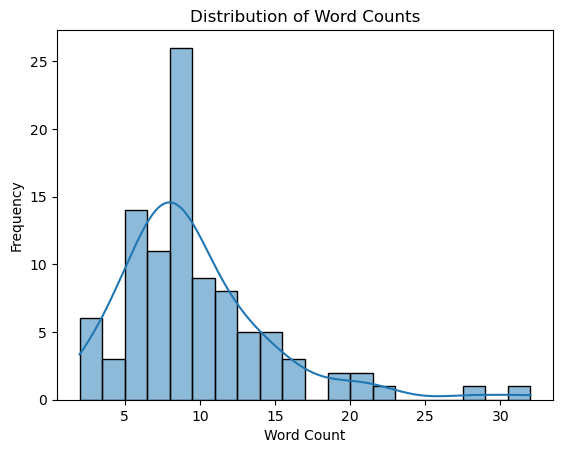

In [8]:
# Plotting the histogram
sns.histplot(df['word_count'], bins=20, kde=True)  # kde=True adds a smooth density line
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

#### Top 10 words in the datasets

In [9]:
all_words = [word for text in df['clean_transcript'] for word in word_tokenize(text.lower())]

# Using FreqDist to calculate frequency
fdist = FreqDist(all_words)

# Converting to DataFrame
word_freq_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
word_freq_df[:10]

,word,frequency
4,a,34
47,ke,31
34,ho,26
1,e,24
16,re,23
54,u,21
23,le,19
5,ka,18
28,o,15
15,ha,15


Word Cloud of all words in the dataset

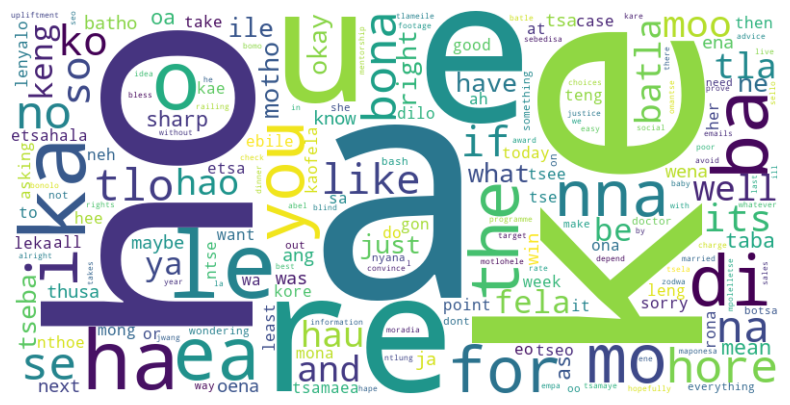

In [10]:
# Generating word cloud from frequency dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Stopwords


In [11]:
# Download latest sesotho stopwords from kaggle
path = kagglehub.dataset_download("rtatman/stopword-lists-for-african-languages")

stop_wordsdf = pd.read_fwf(path+'/st.txt', header=None)
stop_wordsdf.columns = ["word"]
st_stop_words=stop_wordsdf['word'].str.split().sum()

# English Stopwords
en_stop_words = list(set(stopwords.words("english")))

#Combining English and sesotho stopwords
stop_words = list(set(st_stop_words + en_stop_words))
print(stop_words)

['myself', 'ea', 'we', 'so', 'ena', "didn't", 'itself', 're', 'won', 'but', 'is', 'shouldn', 'being', 'his', "hasn't", 'him', 'not', 'mo', 'don', 'most', "she's", 'these', 'she', 'should', 'because', 'aren', "don't", 'then', 'ma', 'you', "hadn't", 'doing', 'now', "mustn't", 'that', 'haven', 'my', 'are', 'eaba', "you'd", 'they', 'of', 'm', 'tloha', 'ourselves', 'which', 'if', "that'll", 'me', 'once', 'has', 'down', "doesn't", 'whom', 'above', 'been', 've', 'from', "aren't", 'both', 'up', 'ba', 'ka', 'to', 'no', 'sa', 'empa', 'la', 'any', 'have', 's', 'those', 'be', 'were', "wasn't", 'ho', 'bona', 'hadn', "it's", "shouldn't", 'couldn', 'each', 'or', 'weren', "shan't", 'few', 'when', 'wasn', 'i', 'hers', 'yourselves', 'where', 'se', 'a', 'own', "couldn't", 't', 'about', 'ke', 'yourself', 'on', 'did', 'having', 'too', "you've", 'through', 'here', 'herself', 'our', 'ha', 'while', 'can', 'their', "isn't", 'do', 'hae', 'what', 'tse', 'nor', "weren't", 'further', 'during', 'am', 'at', 'after',

In [12]:
# Remove stop words
filtered_words = [word for word in all_words if word.lower() not in stop_words]
print("Filtered Text:", " ".join(filtered_words))

Filtered Text: well tlo depend di sales hau ko omantse poor abel neh well na di railing hopefully tla live next week alright kare ntse leka avoid sello win award last year social upliftment nna advice ya motlohele tsamaye tlameile check di emails u batle justice moradia hau win case without footage tla tlo ja dinner ntlung keng rate idea ya hao fela today take easy maponesa mpolelletse baby target ile bomo well bonolo sebedisa information u convince motho u leng charge wena takes seo etsahala ill right etsa mentorship programme ko l ja blind like batla thusa tsee di right choices ona tsela best u leka prove point wa tseba u jwang u u tseba married bless lenyalo rona ene na di rights ah okay okay sharp sharp whatever want okay mean zodwa ga nnyane day care shouldnt agreed taba ela oena mpolella batla whole week nthoe etsahala motho mong mong motho teng holy nna im asking fela nnete fela mean first enele jafta right puleng nna nna claim ang kopa tle ko revival meeting tonight neh batla m

Top10 Frequently used actual words in the dataset, excluding stop words

In [13]:
# Use FreqDist to calculate frequency on filtered_words
fdist = FreqDist(filtered_words)

# Convert to DataFrame
filtered_words_freq_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
#print top 10 most common words
filtered_words_freq_df[:10]

,word,frequency
38,u,21
3,di,11
30,nna,9
11,na,8
1,tlo,8
6,ko,7
80,like,7
81,batla,5
51,hao,5
14,tla,5


Word Cloud of clean dataset

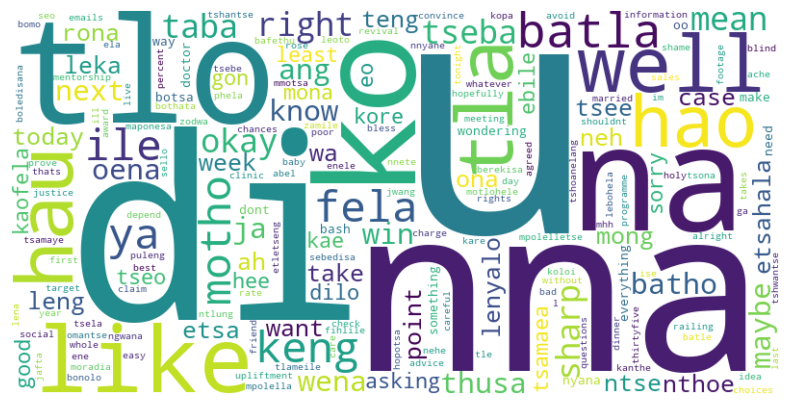

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Removing stop words on each record on the dataset

In [15]:
# Function to remove stop words from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the function to the DataFrame column
df['tokens_cleaned'] = df['tokens'].apply(remove_stopwords)
df['tokens_count'] = df['tokens_cleaned'].str.len()
df.head()


,transcript,audio_paths,clean_transcript,nchars_clean,tokens,word_count,tokens_cleaned,tokens_count
0,well. e tlo. depend. -a ka di. sales. tsa hau.,./audios/AKHONA_12-11-02_237.wav,well e tlo depend a ka di sales tsa hau,39,"[well, e, tlo, depend, a, ka, di, sales, tsa, ...",10,"[well, tlo, depend, di, sales, hau]",6
1,k'o omantse. poor abel. neh.,./audios/AKHONA_12-11-09_140.wav,ko omantse poor abel neh,24,"[ko, omantse, poor, abel, neh]",5,"[ko, omantse, poor, abel, neh]",5
2,well. ha re na di. railing so.,./audios/AKHONA_12-12-13_30.wav,well ha re na di railing so,27,"[well, ha, re, na, di, railing, so]",7,"[well, na, di, railing]",4
3,hopefully. tla be e le. live by next week.,./audios/AKHONA_139_7.wav,hopefully tla be e le live by next week,39,"[hopefully, tla, be, e, le, live, by, next, week]",9,"[hopefully, tla, live, next, week]",5
4,o. alright.,./audios/CALEB_100_239.wav,o alright,9,"[o, alright]",2,[alright],1


In [16]:
print("Total Words: {}". format(df['tokens_count'].sum()))
print(df['tokens_count'].describe())

Total Words: 494
count    97.000000
mean      5.092784
std       2.692901
min       1.000000
25%       3.000000
50%       5.000000
75%       6.000000
max      16.000000
Name: tokens_count, dtype: float64


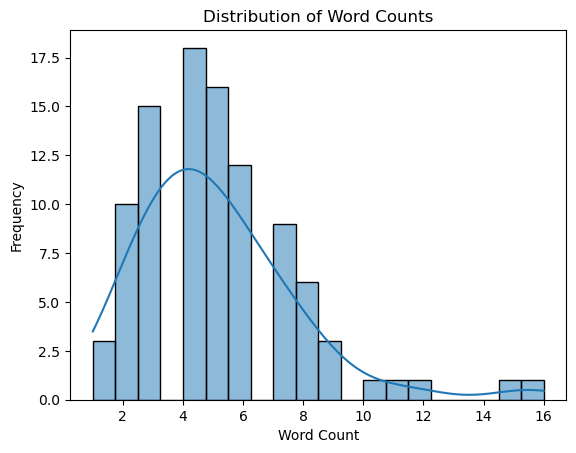

In [17]:
# Plotting the histogram
sns.histplot(df['tokens_count'], bins=20, kde=True)  # kde=True adds a smooth density line
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

### Summary of Findings

- **Initial Text**:
  - **Total Sentences**: 97
  - **Average Sentence Length**: ~9.62 words
  - **Minimum Sentence Length**: 2 words
  - **Maximum Sentence Length**: 32 words
  - **Total Words**: 933
  - **Top 10 Most Used Words**: ['a', 'ke', 'ho', 'e', 're', 'u', 'le', 'ka', 'o', 'ha'].

- **After Removing Stopwords**:
  - **Total Sentences**: 97 (unchanged)
  - **Average Sentence Length**: Reduced to ~5.09 words
  - **Minimum Sentence Length**: Reduced to 1 word
  - **Maximum Sentence Length**: Reduced to 16 words
  - **Total Words**: Reduced to 494
  - **Top 10 Most Used Words**: ['u', 'di', 'nna', 'na', 'tlo', 'ko', 'like', 'batla', 'hao', 'tla']

#### Insights

Initially, the text comprised 97 sentences, with an average length of approximately 9.62 words, a minimum of 2 words, and a maximum of 32 words per sentence, totaling 933 words overall. Nine of the ten most frequently used words all belong to a group of stopwords. Stopwords are common words in a language that carry minimal semantic weight, meaning they contribute little to understanding the primary meaning of a sentence.

After removing the stopwords, the sentence count remained the same, but the average sentence length dropped to about 5.09 words, with sentences ranging from 1 to 16 words in length. The total word count also dropped to **494**. The most frequently used words shifted to content-specific terms such as "u," "di," "nna," "tlo," and "batla," providing a clearer sense of the text's key subjects or actions. This shift highlights how removing stopwords allows for a more focused view of the meaningful language within the text.

<img src="pre-stopwords-hist.png" alt="Histogram of Word Counts Before Stopword Removal" width="500" height="300">
<img src="post-stopwords-hist.png" alt="Histogram of Word Counts After Stopword Removal" width="500" height="300">
<img src="pre-stopwords-wordcloud.png" alt="Word Cloud Before Stopword Removal" width="400" height="400">
<img src="post-stopwords-wordcloud.png" alt="Word Cloud After Stopword Removal" width="400" height="400">

Please see above word cloud and histogram visualizing word counts before and after stopword removal.

The **pre-stopword-removal word cloud** is dominated by frequent, less meaningful words like "a," "ke," "ho," and "e," reflecting the high presence of common or filler words. The histogram of word counts per sentence shows a higher average count, highlighting longer sentences influenced by these additional words. This view provides a sense of overall sentence structure and language flow, but the high frequency of stopwords might obscure key content words.

After removing stopwords, the **word cloud** shifts, giving prominence to content-relevant words like "u," "di," "nna," and "batla," which better reflect the text's themes or actions. The **histogram** also shows reduced word counts per sentence, emphasizing the streamlined, content-focused nature of the remaining words. This post-stopword visual helps reveal core ideas and topics, providing a clearer understanding of the text's message by isolating meaningful words from routine filler words.

# 2. EMA (Exploratory Model Analysis)

### Whisper-Small vs Wav2vec2

In [18]:
# Load Whisper-Small
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [19]:
# Load Wav2Vec2 model
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
wav2vec_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

In [20]:
# Load audio
def load_audio(file_path, target_sample_rate=16000):
    audio, sample_rate = torchaudio.load(file_path)
    if sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        audio = resampler(audio)
    return audio.squeeze().numpy()

In [21]:
# Transcribe audio with Whisper-Small
def transcribe_with_whisper(audio):
    inputs = whisper_processor(audio, return_tensors="pt", sampling_rate=16000)
    output_ids = whisper_model.generate(inputs.input_features)
    transcription = whisper_processor.batch_decode(output_ids, skip_special_tokens=True)[0]
    return transcription


In [22]:
# Transcribe audio with Wav2Vec2
def transcribe_with_wav2vec(audio):
    inputs = wav2vec_processor(audio, return_tensors="pt", sampling_rate=16000)
    logits = wav2vec_model(inputs.input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = wav2vec_processor.batch_decode(predicted_ids)[0]
    return transcription

In [23]:
# Evaluation
whisper_transcriptions = []
wav2vec_transcriptions = []
references = df['transcript'].tolist()  # True transcriptions

for audio_path in df['audio_paths']:
    # Load the audio file
    audio = load_audio(audio_path)
    
    # Get transcriptions
    whisper_transcriptions.append(transcribe_with_whisper(audio))
    wav2vec_transcriptions.append(transcribe_with_wav2vec(audio))


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [24]:
# Calculate CER and WER
whisper_cer = cer(references, whisper_transcriptions)
whisper_wer = wer(references, whisper_transcriptions)
wav2vec_cer = cer(references, wav2vec_transcriptions)
wav2vec_wer = wer(references, wav2vec_transcriptions)

# Display results
print("Whisper-Small CER:", whisper_cer)
print("Whisper-Small WER:", whisper_wer)
print("Wav2Vec2 CER:", wav2vec_cer)
print("Wav2Vec2 WER:", wav2vec_wer)

Whisper-Small CER: 1.3551020408163266
Whisper-Small WER: 1.573576799140709
Wav2Vec2 CER: 0.8968253968253969
Wav2Vec2 WER: 1.0075187969924813


## Summary Findings

To benchmark the performance of **Whisper-Small** and **Wav2Vec2**, we evaluate their **Character Error Rate (CER)** and **Word Error Rate (WER)** to determine the best-performing model. The results are as follows:

- **Whisper-Small**:
  - CER: 1.36
  - WER: 1.57
  
- **Wav2Vec2**:
  - CER: 0.90
  - WER: 1.01

#### Analysis:
- **Character Error Rate (CER)** measures the rate of character-level errors, which gives a granular view of transcription accuracy. Here, **Wav2Vec2** outperforms **Whisper-Small** with a lower CER, indicating fewer character mistakes on average.
  
- **Word Error Rate (WER)** reflects how often entire words are misrecognized, providing a more intuitive measure of practical transcription accuracy. **Wav2Vec2** again has a significantly lower WER, meaning it makes fewer whole-word errors, which would enhance user understanding and require less post-correction.

#### Conclusion:
Given its consistently lower error rates in both CER and WER, **Wav2Vec2** is the better-performing model for transcription accuracy. Its reduced error rates indicate greater reliability in producing both character-accurate and contextually accurate transcriptions, making it the preferred choice for high-accuracy speech-to-text applications. This reliability makes Wav2Vec2 a more suitable option, especially in environments where transcription quality directly impacts usability or requires minimal manual correction.

# 3. Error Analysis (EA)

In [25]:
# Tokenize all words in the wav2vec_transcriptions
all_words = [word for text in wav2vec_transcriptions for word in word_tokenize(text.lower())]

# Remove stop words
filtered_words = [word for word in all_words if word.lower() not in stop_words]

print("Total Predicted Words: {}". format(len(filtered_words)))

# Use FreqDist to calculate frequency
fdist = FreqDist(filtered_words)

# Convert to DataFrame
word_freq_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

print("Top 10 Most Frequent Words: {}". format(word_freq_df[:10]))

Total Predicted Words: 402
Top 10 Most Frequent Words:       word  frequency
14   right          4
85      's          4
77    like          3
143    one          3
12    next          3
81      de          2
130   mean          2
43    take          2
258  would          2
342    way          2


In [26]:

df['predicted_transcripts'] = wav2vec_transcriptions
df['predicted_tokens'] = df['predicted_transcripts'].apply(word_tokenize)
df.head()

,transcript,audio_paths,clean_transcript,nchars_clean,tokens,word_count,tokens_cleaned,tokens_count,predicted_transcripts,predicted_tokens
0,well. e tlo. depend. -a ka di. sales. tsa hau.,./audios/AKHONA_12-11-02_237.wav,well e tlo depend a ka di sales tsa hau,39,"[well, e, tlo, depend, a, ka, di, sales, tsa, ...",10,"[well, tlo, depend, di, sales, hau]",6,WALT GOULD BEEN THEIR SAILS TO HELM,"[WALT, GOULD, BEEN, THEIR, SAILS, TO, HELM]"
1,k'o omantse. poor abel. neh.,./audios/AKHONA_12-11-09_140.wav,ko omantse poor abel neh,24,"[ko, omantse, poor, abel, neh]",5,"[ko, omantse, poor, abel, neh]",5,GOMIN TO POOR ABEL NOW,"[GOMIN, TO, POOR, ABEL, NOW]"
2,well. ha re na di. railing so.,./audios/AKHONA_12-12-13_30.wav,well ha re na di railing so,27,"[well, ha, re, na, di, railing, so]",7,"[well, na, di, railing]",4,LL ADNAD RAILING SO,"[LL, ADNAD, RAILING, SO]"
3,hopefully. tla be e le. live by next week.,./audios/AKHONA_139_7.wav,hopefully tla be e le live by next week,39,"[hopefully, tla, be, e, le, live, by, next, week]",9,"[hopefully, tla, live, next, week]",5,HAPLY EARLY LIFE BY NEXT WEEK,"[HAPLY, EARLY, LIFE, BY, NEXT, WEEK]"
4,o. alright.,./audios/CALEB_100_239.wav,o alright,9,"[o, alright]",2,[alright],1,ALL RIGHT,"[ALL, RIGHT]"


In [27]:
# Function to remove stop words from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the function to the DataFrame column
df['predicted_tokens_cleaned'] = df['predicted_tokens'].apply(remove_stopwords)
df['predicted_Wcount'] = df['predicted_tokens_cleaned'].str.len()
df.head()

,transcript,audio_paths,clean_transcript,nchars_clean,tokens,word_count,tokens_cleaned,tokens_count,predicted_transcripts,predicted_tokens,predicted_tokens_cleaned,predicted_Wcount
0,well. e tlo. depend. -a ka di. sales. tsa hau.,./audios/AKHONA_12-11-02_237.wav,well e tlo depend a ka di sales tsa hau,39,"[well, e, tlo, depend, a, ka, di, sales, tsa, ...",10,"[well, tlo, depend, di, sales, hau]",6,WALT GOULD BEEN THEIR SAILS TO HELM,"[WALT, GOULD, BEEN, THEIR, SAILS, TO, HELM]","[WALT, GOULD, SAILS, HELM]",4
1,k'o omantse. poor abel. neh.,./audios/AKHONA_12-11-09_140.wav,ko omantse poor abel neh,24,"[ko, omantse, poor, abel, neh]",5,"[ko, omantse, poor, abel, neh]",5,GOMIN TO POOR ABEL NOW,"[GOMIN, TO, POOR, ABEL, NOW]","[GOMIN, POOR, ABEL]",3
2,well. ha re na di. railing so.,./audios/AKHONA_12-12-13_30.wav,well ha re na di railing so,27,"[well, ha, re, na, di, railing, so]",7,"[well, na, di, railing]",4,LL ADNAD RAILING SO,"[LL, ADNAD, RAILING, SO]","[ADNAD, RAILING]",2
3,hopefully. tla be e le. live by next week.,./audios/AKHONA_139_7.wav,hopefully tla be e le live by next week,39,"[hopefully, tla, be, e, le, live, by, next, week]",9,"[hopefully, tla, live, next, week]",5,HAPLY EARLY LIFE BY NEXT WEEK,"[HAPLY, EARLY, LIFE, BY, NEXT, WEEK]","[HAPLY, EARLY, LIFE, NEXT, WEEK]",5
4,o. alright.,./audios/CALEB_100_239.wav,o alright,9,"[o, alright]",2,[alright],1,ALL RIGHT,"[ALL, RIGHT]",[RIGHT],1


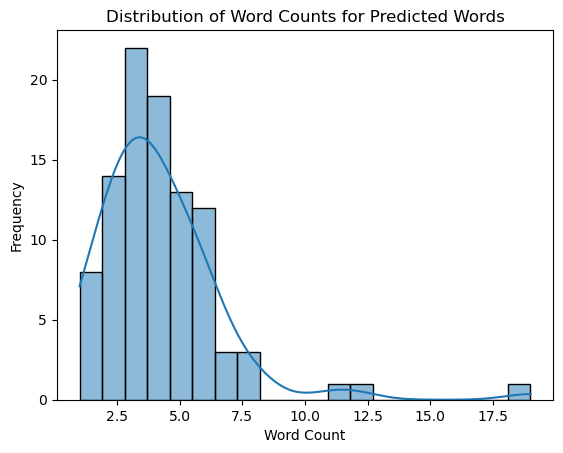

In [29]:
# Plotting the histogram
sns.histplot(df['predicted_Wcount'], bins=20, kde=True)  # kde=True adds a smooth density line
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts for Predicted Words')
plt.show()

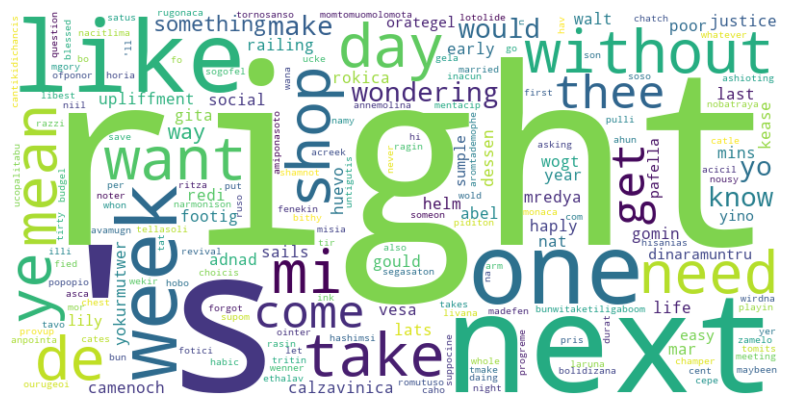

In [30]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()